### Introduction


Anomaly detection is the task of finding/identifying unexpected events/data points which differ from the normal behaviour. In general, anomally detection is applied on unlabelled data with an unsupervised model. 

Adopting simple anomaly approaches to a time series data could  be more difficult because in time series data large number of false anomalies are generated, some methods are not applicable to changing data values and simple approaches may not easily scale arge time series.

There are a lot of approaches for outlier detection. Some of them are: 

Principal Component Analysis (procedure which transforms some (possibly) correlated variables into a smaller number of uncorrelated variables. )

Minimum Covariance Determinant (specifies an ellipsoid the circumscribes the primary dimensions of the data in N-space)

One-Class Support Vector Machine (OCSVM)(to train a classification model that can distinguish normal data from outliers)

Cluster-based Local Outlier Factor (first cluster the dataset using the k-means algorithm and then use the distance from the data instance to the centroid )

Histogram-based Outlier Score (creates a histogram with a fixed or a dynamic binwidth with which it calculates an outlier score)

K-Nearest Neighbours (the normal points have close neighbours while anomalies are situated far from other points)

Angle-based Outlier Detection (ABOD) (the angles are more stable than distances in a high dimensional space)

Isolation Forest (instead of profiling normal data points, it explicitly determines the anomalous data points.The outliers are identified closer to the root of a tree with fewer splits using random sampling)

Feature Bagging and Autoencoders (Outlier detection is executed in several random feature subsets (subspaces). Then, Combine results in an ensemble)

Autoencoders: an artificial neural network that learns from the representation (encoding) for a set of data points.


### Summary of the Project

In this project, I will try to detect the anomalies in a smart home-security system consisting of 12 sensors (receiving info of temperature, humidity, CO2 level) that create continues time series data in every 10 minutes (real data is from an IoT-acquired landfill site sensor data, Ambisense Ltd. Dublin)

 When there is an excessive deviation of the value from the mean, at that point we can consider this data point as anomalous.Relatively impossible values in the sensor data stream can be thought as anomalous. Since we are dealing with time series data, it is difficult to find a one fit all solution for the problem that we are addressing.

I will use an LSTM Autoencoder Neural Network to detect/predict anomalies in the historical sensor data. It is an anomally detection technique that analyzes the degree to which incoming data is different than data that the data you used to train the neural network. An autoencoder has two parts: an encoder and the decoder.The output layer has the same number nodes as that of the input layer and an autoencoder is trained to reconstruct its own inputs. Autoencoders aim at reducing feature space and keeping essential features.

In this project, after data preprocessing and explaratory data analysis (EDA), I will create a recurrent neural network model First, autoencoders will be trained on train data with regularization, then i will evaluate the model on the validation set with visualizing the error plot. After evaluating the errors, there is a need to create a threshold function. Then classify the values above/below the threshold lines as anomalies.



## Read and Preprocess

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import keras
import seaborn as sns
import matplotlib.pyplot as plt
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly


In [2]:
df=pd.read_csv('BH2S.csv', index_col=0)

In [3]:
df.head()

,senseDate,CH4,CO2,O2,Temp,Humidity,PumpPres,GaugePres,BaroPres
0,3/30/2016 16:55,0.17,0.12,21.01,15.78,54.37,-25.18,0.24,1007.31
1,3/30/2016 17:06,0.16,0.13,20.83,14.25,57.39,-25.22,0.00,1007.79
2,3/30/2016 18:03,0.13,0.13,20.61,11.48,72.91,-25.57,0.00,1008.26
3,3/30/2016 19:01,0.16,0.14,20.53,10.09,69.12,-25.36,0.00,1008.74
4,3/30/2016 19:59,0.16,0.14,20.37,7.56,71.46,-25.78,0.00,1009.70


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13031 entries, 0 to 13030
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   senseDate  13031 non-null  object 
 1   CH4        13024 non-null  float64
 2   CO2        13031 non-null  float64
 3   O2         13031 non-null  float64
 4   Temp       13031 non-null  float64
 5   Humidity   13031 non-null  float64
 6   PumpPres   13031 non-null  float64
 7   GaugePres  13031 non-null  float64
 8   BaroPres   13031 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1018.0+ KB


In [5]:
df.senseDate=pd.to_datetime(df.senseDate)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13031 entries, 0 to 13030
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   senseDate  13031 non-null  datetime64[ns]
 1   CH4        13024 non-null  float64       
 2   CO2        13031 non-null  float64       
 3   O2         13031 non-null  float64       
 4   Temp       13031 non-null  float64       
 5   Humidity   13031 non-null  float64       
 6   PumpPres   13031 non-null  float64       
 7   GaugePres  13031 non-null  float64       
 8   BaroPres   13031 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 1018.0 KB


Before we can feed data into the neural network we must perform some preprocessing. 

In [7]:
df.describe(include='all')

,senseDate,CH4,CO2,O2,Temp,Humidity,PumpPres,GaugePres,BaroPres
count,13031,13024.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000,13031.000000
unique,13028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-12-07 12:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2016-03-30 16:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2017-11-17 16:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,34.688886,2.872547,10.455221,11.541391,87.226744,-24.299246,-0.539322,1016.291050
std,NaN,29.566755,1.588534,6.965685,6.541824,16.179594,9.014698,0.730354,9.313949
min,NaN,0.020000,0.020000,0.000000,-2.490000,15.060000,-120.750000,-3.720000,980.540000
25%,NaN,2.600000,1.610000,4.655000,6.740000,82.835000,-27.630000,-0.990000,1010.650000



Lets check the correlation between features, trends and seasonal/daily changes in the data


In [8]:
corrm = df.corr()
corrm

,CH4,CO2,O2,Temp,Humidity,PumpPres,GaugePres,BaroPres
CH4,1.000000,0.840162,-0.976395,0.269242,-0.335115,0.498984,-0.434924,-0.131585
CO2,0.840162,1.000000,-0.910890,0.206293,-0.452575,0.540637,-0.500423,-0.049365
O2,-0.976395,-0.910890,1.000000,-0.255510,0.399595,-0.520597,0.461561,0.128655
Temp,0.269242,0.206293,-0.255510,1.000000,-0.414384,0.006682,-0.544199,-0.112487
Humidity,-0.335115,-0.452575,0.399595,-0.414384,1.000000,-0.439567,0.278362,0.049449
PumpPres,0.498984,0.540637,-0.520597,0.006682,-0.439567,1.000000,-0.047035,-0.142173
GaugePres,-0.434924,-0.500423,0.461561,-0.544199,0.278362,-0.047035,1.000000,0.074231
BaroPres,-0.131585,-0.049365,0.128655,-0.112487,0.049449,-0.142173,0.074231,1.000000


We can see that CH4 and CO2 are highly (positively) correlated, and CO2 and O2 are highly (negatively) correlated. 

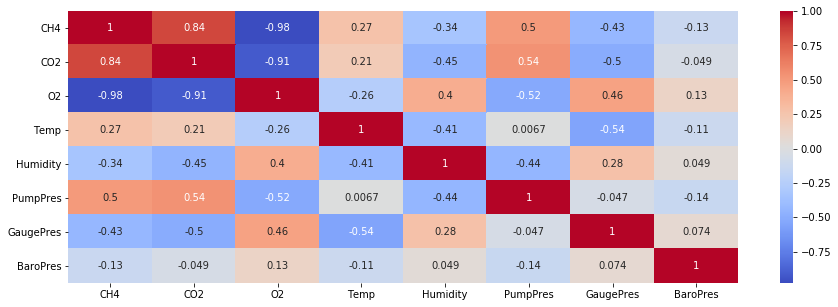

In [9]:
plt.figure(figsize=(15,5))
heatmapdf = sns.heatmap(df.corr(), cmap='coolwarm',annot=True)

<!-- We can see that, co2 and ch4 are highly (positively) correlated -->

In [10]:
df.columns

Index(['senseDate', 'CH4', 'CO2', 'O2', 'Temp', 'Humidity', 'PumpPres',
       'GaugePres', 'BaroPres'],
      dtype='object')

We will use only CO2 data for our training model

In [11]:

df.drop(['CH4', 'O2', 'Temp', 'Humidity', 'PumpPres',
       'GaugePres', 'BaroPres'], axis=1, inplace=True)

In [12]:
df.set_index('senseDate', inplace=True)
df.head()

,CO2
senseDate,
2016-03-30 16:55:00,0.12
2016-03-30 17:06:00,0.13
2016-03-30 18:03:00,0.13
2016-03-30 19:01:00,0.14
2016-03-30 19:59:00,0.14


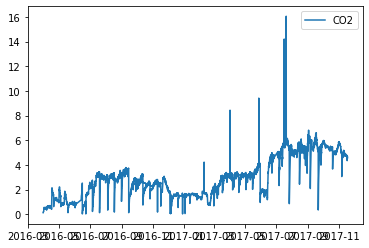

In [13]:
plt.plot(df, label='CO2')
plt.legend();

## Inferential Statistics


Let's perform a hypothesis testing,
Null Hypothesis: CO2 sensor data  is a normal distribution
Alternate Hypothesis: CO2 sensor data  is a normal distribution
Significance level alpha is 0.05

In [14]:
from scipy import stats
stats.normaltest(df.CO2)

NormaltestResult(statistic=596.9662967760688, pvalue=2.346473824795779e-130)

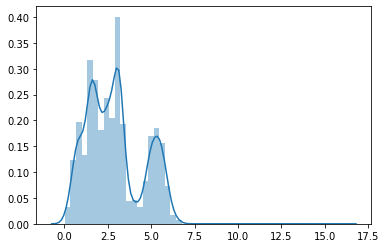

In [15]:
sns.distplot(df)

Since the value of p is smaller than 0.05 (almost zero), we can  reject the null hypothesis. The data is not normally distributed

In [16]:
from sklearn import preprocessing
x_array = np.array(df['CO2'])
normalized_X = preprocessing.normalize([x_array])
dftest=pd.DataFrame(normalized_X)
dftest=dftest.transpose()
dftest.head()


,0
0,0.000320
1,0.000347
2,0.000347
3,0.000374
4,0.000374


In [17]:
stats.normaltest(dftest)

NormaltestResult(statistic=array([596.96629678]), pvalue=array([2.34647382e-130]))

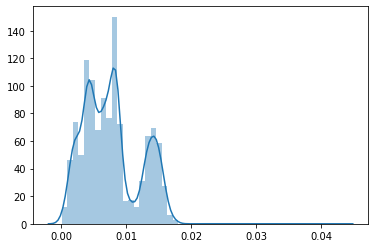

In [18]:
sns.distplot(dftest)

In [19]:
train_size = int(len(df) * 0.85)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(11076, 1) (1955, 1)


In [20]:

scaler = StandardScaler()
scaler = scaler.fit(train[['CO2']])
train['CO2'] = scaler.transform(train[['CO2']])
test['CO2'] = scaler.transform(test[['CO2']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Creating series and Model

In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Let's create sequences with 10 days worth of historical data:

In [22]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['CO2']],train.CO2,TIME_STEPS)
X_test, y_test = create_dataset(test[['CO2']],test.CO2,TIME_STEPS)
print(X_train.shape)

(11046, 30, 1)


In [23]:

model = keras.Sequential()
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [24]:
history = model.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/10
311/311 [==============================] - 7s 24ms/step - loss: 0.1526 - val_loss: 0.3711
Epoch 2/10
311/311 [==============================] - 7s 21ms/step - loss: 0.1000 - val_loss: 0.3323
Epoch 3/10
311/311 [==============================] - 7s 21ms/step - loss: 0.0853 - val_loss: 0.3181
Epoch 4/10
311/311 [==============================] - 7s 21ms/step - loss: 0.0762 - val_loss: 0.1876
Epoch 5/10
311/311 [==============================] - 7s 21ms/step - loss: 0.0722 - val_loss: 0.1613
Epoch 6/10
311/311 [==============================] - 7s 23ms/step - loss: 0.0705 - val_loss: 0.2244
Epoch 7/10
311/311 [==============================] - 7s 23ms/step - loss: 0.0689 - val_loss: 0.1407
Epoch 8/10
311/311 [==============================] - 7s 24ms/step - loss: 0.0667 - val_loss: 0.1089
Epoch 9/10
311/311 [==============================] - 8s 24ms/step - loss: 0.0682 - val_loss: 0.2274
Epoch 10/10
311/311 [==============================] - 8s 27ms/step - loss: 0.0670 - val_lo

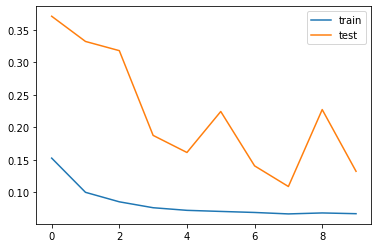

In [25]:
# compare the trian test error

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

Let’s calculate the Mean Absolute Error (MAE) on the training data:

In [26]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

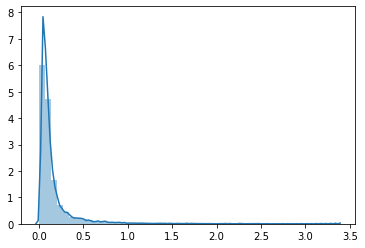

In [27]:

sns.distplot(train_mae_loss, bins=50);

Let's pick a threshold of 0.6
Above this will be categorized as anomaly

## Applying a threshold and classify anomalies

In [28]:
th=0.6
# calculate the error on test data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [29]:
# create a new dataframe containing of loss and errors above threshold
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = th
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['CO2'] = test[TIME_STEPS:].CO2

In [30]:
test_score_df.head()

,loss,threshold,anomaly,CO2
senseDate,,,,
2017-08-20 22:16:00,0.161848,0.6,False,2.286426
2017-08-20 23:18:00,0.161554,0.6,False,2.294075
2017-08-21 00:20:00,0.155707,0.6,False,2.301723
2017-08-21 01:22:00,0.147856,0.6,False,2.339968
2017-08-21 02:24:00,0.127670,0.6,False,2.317021


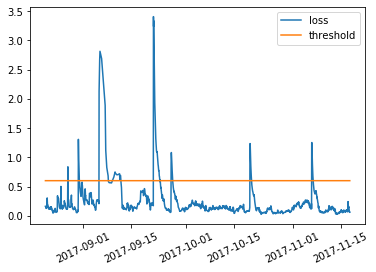

In [31]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [32]:

anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,CO2
senseDate,,,,
2017-08-27 11:32:00,0.837336,0.6,True,1.934579
2017-08-30 13:02:00,1.307208,0.6,True,1.131449
2017-08-30 14:05:00,1.087324,0.6,True,1.207938
2017-08-30 15:07:00,0.953660,0.6,True,1.261480
2017-08-30 16:09:00,0.863344,0.6,True,1.315022
...,...,...,...,...
2017-11-06 20:09:00,0.786680,0.6,True,1.032014
2017-11-06 21:10:00,0.720858,0.6,True,1.054961
2017-11-06 22:12:00,0.677442,0.6,True,1.100854


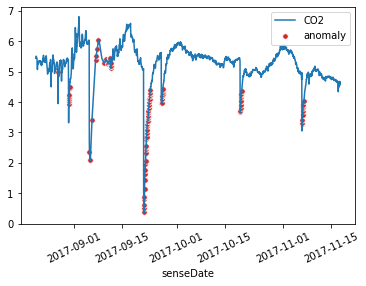

In [33]:
plt.plot(test[TIME_STEPS:].index, scaler.inverse_transform(test[TIME_STEPS:].CO2), label='CO2');
# plt.figure(figsize=(15,8))
sns.scatterplot(anomalies.index,scaler.inverse_transform(anomalies.CO2),color=sns.color_palette()[3],s=30, label='anomaly')
plt.xticks(rotation=25)
plt.legend();

## Suggestions

### Areas of Imporvement

- Other anomaly detection algorthms can be experimented.

- Our time series data set was an unlabelled data set and we created an unsupervised model using LSTM Autoencoders. If we have a labelled data, it will be better to compare our prediction results with real values, with precision, recall, F1 scores and ROC curves 

- If we have different sensors devices for the same feature (ie: 4 sensors for CO2) data, we could do more statistical comparisons,

- More data explorations such as timely performance of sensors (day/night, weekdays/weekends, summer/winter etc) could be done. (Facebook Prphet library can be used)

- Adding some functions for selecting best hyper parameters, such as early stopping for epochs.